In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import pandas as pd

import model_predict
from sklearn.model_selection import train_test_split

In [2]:
series, scaler = model_predict.read_data_series(scale=True, filter_early=True, file_index=4)

时间序列不连贯，缺失的月份： ['2018-02', '2018-12', '2019-02', '2019-12', '2020-11', '2020-12', '2021-01', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02']
即将填充缺失的月份
月份平均：
月份
1     541.336000
2     399.416000
3     638.322000
4     612.754909
5     653.405818
6     728.001455
7     610.260364
8     718.357818
9     753.433455
10    658.463200
11    585.294667
12    288.616571
Name: 销量（箱）, dtype: float64


In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        
        self.gru = nn.GRU(input_size, hidden_size,
                          num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch, length, 3]
        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])
        # log_var, mean = x.split(1, dim=-1)
        # x = torch.randn_like(mean) * torch.exp(log_var / 2) + mean
        return x


model_parameters = {
    "input_size": 3, "hidden_size": 12, "num_layers": 1, "output_size": 1
}

In [4]:
from importlib import reload
reload(model_predict)
model_predict.train_rnn_model(GRUModel, model_parameters, series, learn_rate=1e-3, feature_length=16,
                              continue_train=False, test_shuffle=True, epochs=1000)

训练 GRUModel 模型
结果保存到： GRUModel_best.pth
Epoch [50/1000], Learn Rate: 1.0000e-03, Training Loss: 0.3273, Validation Loss: 0.2808
Epoch [100/1000], Learn Rate: 1.0000e-03, Training Loss: 0.2767, Validation Loss: 0.2451
Epoch [150/1000], Learn Rate: 1.0000e-03, Training Loss: 0.2150, Validation Loss: 0.2467
Epoch [200/1000], Learn Rate: 1.0000e-03, Training Loss: 0.1572, Validation Loss: 0.2804
Epoch [250/1000], Learn Rate: 1.0000e-03, Training Loss: 0.1108, Validation Loss: 0.3697
Epoch [300/1000], Learn Rate: 1.0000e-03, Training Loss: 0.0781, Validation Loss: 0.4341
Epoch [350/1000], Learn Rate: 1.0000e-03, Training Loss: 0.0597, Validation Loss: 0.4408
Epoch [400/1000], Learn Rate: 1.0000e-03, Training Loss: 0.0428, Validation Loss: 0.4362
Epoch [450/1000], Learn Rate: 1.0000e-03, Training Loss: 0.0277, Validation Loss: 0.4058
Epoch [500/1000], Learn Rate: 1.0000e-03, Training Loss: 0.0179, Validation Loss: 0.3755
Epoch [550/1000], Learn Rate: 1.0000e-03, Training Loss: 0.0124, Valida

从2021年3月开始后续数据推理
MSE: 9.97
MAE: 2.69
R^2: 1.00
MAPE: 0.00


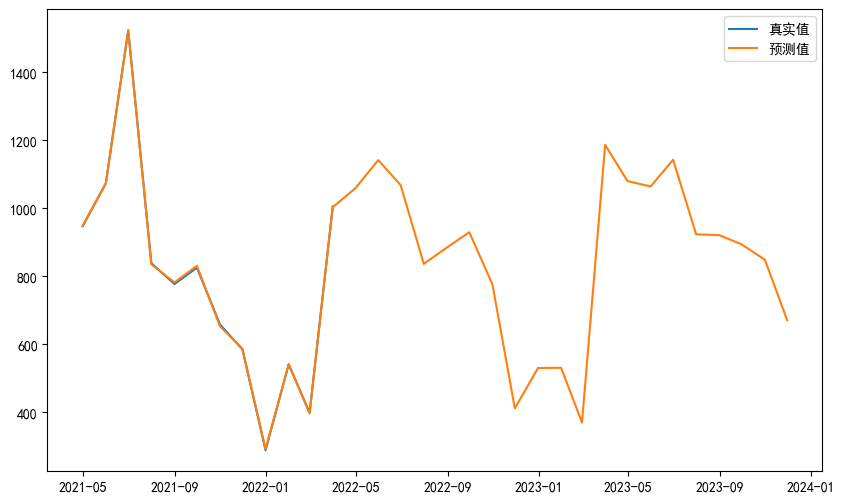

2021-04-30     949.185187
2021-05-31    1074.204798
2021-06-30    1522.598664
2021-07-31     835.342243
2021-08-31     782.509011
2021-09-30     831.028541
2021-10-31     653.100630
2021-11-30     587.057026
2021-12-31     292.134788
2022-01-31     542.171435
2022-02-28     396.924113
2022-03-31    1003.666515
2022-04-30    1058.708034
2022-05-31    1142.116361
2022-06-30    1068.687880
2022-07-31     837.005528
2022-08-31     885.070199
2022-09-30     930.004449
2022-10-31     776.528709
2022-11-30     411.940104
2022-12-31     530.571283
2023-01-31     531.359157
2023-02-28     370.223564
2023-03-31    1186.868344
2023-04-30    1080.391871
2023-05-31    1064.793841
2023-06-30    1143.172413
2023-07-31     923.975312
2023-08-31     921.373121
2023-09-30     894.162895
2023-10-31     849.061647
2023-11-30     670.750232
Freq: M, dtype: float64

In [7]:
model = model_predict.load_rnn_model_best(GRUModel, model_parameters)
model_predict.predict_to_future_rnn(model, series, scaler, feature_length=16, last_months=12, months=32)